In [118]:
# formatting the screen

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

pd.set_option("display.max_columns", 40)

In [ ]:
# Libraries

import numpy as np


In [ ]:
# Get Chunk = 1000

chunk_1 = pd.read_csv('221221COVID19MEXICO.csv', chunksize = 1000)

In [ ]:
chunk_1.get_chunk(1000)

### Catálogos en Excel

In [ ]:
# Obtain sheet names in xlsx

cat = pd.read_excel('201128_Catalogos.xlsx', None);
cat.keys()

In [ ]:
# Read Catálogo RESULTADO_LAB

cat = pd.read_excel('201128_Catalogos.xlsx', 'Catálogo RESULTADO_LAB');
#cat1.rename(columns = {'CLAVE_ENTIDAD' : 'ENTIDAD_NAC'}, inplace = True)
cat

In [ ]:
# Read Catálogo CLASIFICACION_FINAL

cat1 = pd.read_excel('201128_Catalogos.xlsx', 'Catálogo CLASIFICACION_FINAL');
#cat1.rename(columns = {'CLAVE_ENTIDAD' : 'ENTIDAD_NAC'}, inplace = True)
cat1

In [ ]:
# Read Catálogo RESULTADO_ANTIGENO

cat2 = pd.read_excel('201128_Catalogos.xlsx', 'Catálogo RESULTADO_ANTIGENO');
#cat1.rename(columns = {'CLAVE_ENTIDAD' : 'ENTIDAD_NAC'}, inplace = True)
cat2

In [ ]:
# Read Catálogo de Entidades

cat3 = pd.read_excel('201128_Catalogos.xlsx', 'Catálogo de ENTIDADES');
cat3.rename(columns = {'CLAVE_ENTIDAD' : 'ENTIDAD_NAC'}, inplace = True)
cat3

### Crear casos_confirmados

In [ ]:
# Load data

data = pd.read_csv('221221COVID19MEXICO.csv', sep = ',')
data['FECHA_ACTUALIZACION'] = pd.to_datetime(data['FECHA_ACTUALIZACION'], dayfirst=True)
data['FECHA_INGRESO'] = pd.to_datetime(data['FECHA_INGRESO'], dayfirst=True)

In [ ]:
# Crear casos_confirmados

casos_confirmados = data[ (data.CLASIFICACION_FINAL == 1) | (data.CLASIFICACION_FINAL == 2) | (data.CLASIFICACION_FINAL == 3)]

In [ ]:
# Shape casos_confirmados

casos_confirmados.shape

In [ ]:
# Reemplazar FECHA_DEF 

casos_confirmados['FECHA_DEF'].replace('9999-99-99', np.NaN, inplace = True)
print(casos_confirmados['FECHA_DEF'].isnull().sum())

In [ ]:
# Formato datetime FECHA_DEF

casos_confirmados['FECHA_DEF'] = pd.to_datetime(casos_confirmados['FECHA_DEF'], dayfirst=True)

In [ ]:
casos_confirmados.info()

In [ ]:
# Reemplazar datos

# Catálogo Tipo Paciente
casos_confirmados['TIPO_PACIENTE'].replace([1, 2, 3],['Ambulatorio', 'Hospitalizado', 'No_Especificado'], inplace = True)

# Catálogo Sexo
casos_confirmados['SEXO'].replace([1, 2],['Mujer', 'Hombre'], inplace = True)

# Catálogo Entidades
casos_confirmados = pd.merge(casos_confirmados, cat3, on ='ENTIDAD_NAC', how ='left')

# Catálogo Clasificación Final
data['CLASIFICACION_FINAL'].replace([1], ['Caso_de_COVID-19_confirmado_por_asociación_Clínica_Epidemiológica'])
data['CLASIFICACION_FINAL'].replace([2], ['Caso_de_COVID-19_confirmado_por_Comité_de_Dictaminación'])
data['CLASIFICACION_FINAL'].replace([3], ['Caso_de_SARS-COV-2_Confirmado'])

# Catálogo Resultado Antígeno
casos_confirmados['RESULTADO_ANTIGENO'].replace([1, 2, 97],['Positivo_a_SARS_COV_2', 'Negativo_a_SARS_COV_2', 'No_Aplica_Caso_sin_Muestra'], inplace = True)

In [ ]:
# Adicionar columna Evento 

casos_confirmados['EVENTO'] = 1
#data.head()

In [ ]:
# Save data_ing_hom

casos_confirmados.to_csv('casos_confirmados.csv')

# 01 Crear data_ing_2

In [ ]:
# Load data

data_ing = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_INGRESO', 'ENTIDAD_FEDERATIVA', 'EVENTO'])

In [ ]:
# Agrupar eventos por fecha

data_ing_2 = data_ing.groupby(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], as_index = False)["EVENTO"].count()

In [ ]:
# Acumular Eventos en ING_ACUM 

data_ing_2['ING_ACUM'] = data_ing_2[['ENTIDAD_FEDERATIVA', 'EVENTO']].groupby('ENTIDAD_FEDERATIVA').cumsum()

In [ ]:
# Verificar data

data_ing_2.head()

In [ ]:
# Save data_ing_2

data_ing_2.to_csv('data_ing_2.csv')

### Rellenar fechas vacías

In [ ]:
# Load data

data_ing_2 = pd.read_csv('data_ing_2.csv')

In [ ]:

data_ing_2['FECHA_INGRESO'] = pd.to_datetime(data_ing_2['FECHA_INGRESO'], dayfirst=True)
data_ing_2 = data_ing_2.set_index('FECHA_INGRESO')
#data_ing_2 = data_ing_2.set_index('FECHA_INGRESO').groupby('ENTIDAD_FEDERATIVA')

In [ ]:
data_ing_2.head()

In [ ]:
# Fill empty backwards dates

data_ing_3 = pd.DataFrame()
for id_val, obs_period in data_ing_2.groupby('ENTIDAD_FEDERATIVA'):
#for id_val, obs_period in data_ing_2:
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['ENTIDAD_FEDERATIVA'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'ING_ACUM']):
        obs_period.at[obs_period.index[0], 'ING_ACUM'] = 0
    obs_period = obs_period.ffill()
    data_ing_3 = pd.concat([data_ing_3, obs_period])


In [ ]:


data_ing_3.reset_index(inplace = True)
data_ing_3.rename(columns = {'index' : 'FECHA_INGRESO'}, inplace = True)

In [ ]:
data_ing_4 = data_ing_3[data_ing_3['FECHA_INGRESO'] > '2020-02-26']

In [ ]:
# fill empty dates to the present

present = '2021-12-22'

data_ing_4['FECHA_INGRESO'] = pd.to_datetime(data_ing_4['FECHA_INGRESO'])
#today = pd.Timestamp('today')
def expand_dates(grp):
    start = grp.index.min()
    end = present
    index = pd.date_range(start, end, freq='D')
    return grp.reindex(index).ffill()
data_ing_4 = data_ing_4.set_index('FECHA_INGRESO')
data_ing_4 = data_ing_4.groupby('ENTIDAD_FEDERATIVA')['ING_ACUM'].apply(expand_dates)
data_ing_4 = data_ing_4.to_frame()
data_ing_4.reset_index(inplace = True)
data_ing_4.rename(columns = {'level_1' : 'FECHA_INGRESO'}, inplace = True)

In [ ]:
#data_ing_4 = data_ing_4.sort_values(by ='FECHA_INGRESO', ascending = True)
data_ing_4 = data_ing_4.sort_values(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], ascending = (True, True))

In [ ]:
# Save data_ing_final

data_ing_4.to_csv('data_ing_final.csv')

### Verificar bases

In [ ]:
current_date = '2020-02-28'
#dia_muestra_1 = data_ing_2[data_ing_2['FECHA_INGRESO'].eq(current_date)]
dia_muestra_2 = data_ing_2[data_ing_2['FECHA_INGRESO'].eq(current_date)]
dia_muestra_3 = data_ing_3[data_ing_3['FECHA_INGRESO'].eq(current_date)]

In [ ]:
# Dataframes side by side

from IPython.display import display_html 

df1 = dia_muestra_2
df2 = dia_muestra_3


df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('df1')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('df2')
df2_t_styler = df2.T.style.set_table_attributes("style='display:inline'").set_caption('df2_t')

space = "\xa0" * 20
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

#display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
#display_html(df1_styler._repr_html_()+df2_styler._repr_html_() +df2_t_styler._repr_html_(), raw=True)

# 02 Crear data_ing_hom

In [ ]:
# Load data

#data_ing_hom = pd.read_csv('casos_confirmados.csv', sep = ',')
data_ing_hom = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_INGRESO', 'ENTIDAD_FEDERATIVA', 'EVENTO', 'SEXO'])

In [ ]:
data_ing_hom.info()

In [ ]:
# Select Hombre in DataFrame

data_ing_hom = data_ing_hom[data_ing_hom['SEXO'].str.contains('Hombre')]

In [ ]:
# Agrupar eventos por fecha

data_ing_hom = data_ing_hom.groupby(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], as_index = False)["EVENTO"].count()

In [ ]:
# Acumular Eventos en ING_ACUM 

data_ing_hom['ING_ACUM'] = data_ing_hom[['ENTIDAD_FEDERATIVA', 'EVENTO']].groupby('ENTIDAD_FEDERATIVA').cumsum()

### Rellenar fechas vacías

In [ ]:
data_ing_hom['FECHA_INGRESO'] = pd.to_datetime(data_ing_hom['FECHA_INGRESO'], dayfirst=True)
data_ing_hom = data_ing_hom.set_index('FECHA_INGRESO')
#data_ing_2 = data_ing_2.set_index('FECHA_INGRESO').groupby('ENTIDAD_FEDERATIVA')

In [ ]:
# Fill empty backwards dates

data_ing_hom_2 = pd.DataFrame()
for id_val, obs_period in data_ing_hom.groupby('ENTIDAD_FEDERATIVA'):
#for id_val, obs_period in data_ing_2:
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['ENTIDAD_FEDERATIVA'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'ING_ACUM']):
        obs_period.at[obs_period.index[0], 'ING_ACUM'] = 0
    obs_period = obs_period.ffill()
    data_ing_hom_2 = pd.concat([data_ing_hom_2, obs_period])


In [ ]:


data_ing_hom_2.reset_index(inplace = True)
data_ing_hom_2.rename(columns = {'index' : 'FECHA_INGRESO'}, inplace = True)

In [ ]:
data_ing_hom_3 = data_ing_hom_2[data_ing_hom_2['FECHA_INGRESO'] > '2020-02-26']

In [ ]:
# fill empty dates to the present

present = '2021-12-22'

data_ing_hom_3['FECHA_INGRESO'] = pd.to_datetime(data_ing_hom_3['FECHA_INGRESO'])
#today = pd.Timestamp('today')
def expand_dates(grp):
    start = grp.index.min()
    end = present
    index = pd.date_range(start, end, freq='D')
    return grp.reindex(index).ffill()
data_ing_hom_3 = data_ing_hom_3.set_index('FECHA_INGRESO')
data_ing_hom_3 = data_ing_hom_3.groupby('ENTIDAD_FEDERATIVA')['ING_ACUM'].apply(expand_dates)
data_ing_hom_3 = data_ing_hom_3.to_frame()
data_ing_hom_3.reset_index(inplace = True)
data_ing_hom_3.rename(columns = {'level_1' : 'FECHA_INGRESO'}, inplace = True)

In [ ]:
#data_ing_4 = data_ing_4.sort_values(by ='FECHA_INGRESO', ascending = True)
data_ing_hom_3 = data_ing_hom_3.sort_values(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], ascending = (True, True))

In [ ]:
# Save data_ing_hom

data_ing_hom_3.to_csv('data_ing_hom_final.csv')

# 03 Crear data_ing_muj

In [ ]:
# Load data

data_ing_muj = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_INGRESO', 'ENTIDAD_FEDERATIVA', 'EVENTO', 'SEXO'])

In [ ]:
data_ing_muj.info()

In [ ]:
# Select Hombre in DataFrame

data_ing_muj = data_ing_muj[data_ing_muj['SEXO'].str.contains('Mujer')]

In [ ]:
# Agrupar eventos por fecha

data_ing_muj = data_ing_muj.groupby(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], as_index = False)["EVENTO"].count()

In [ ]:
# Acumular Eventos en ING_ACUM 

data_ing_muj['ING_ACUM'] = data_ing_muj[['ENTIDAD_FEDERATIVA', 'EVENTO']].groupby('ENTIDAD_FEDERATIVA').cumsum()

### Rellenar fechas vacías

In [ ]:
data_ing_muj['FECHA_INGRESO'] = pd.to_datetime(data_ing_muj['FECHA_INGRESO'], dayfirst=True)
data_ing_muj = data_ing_muj.set_index('FECHA_INGRESO')
#data_ing_2 = data_ing_2.set_index('FECHA_INGRESO').groupby('ENTIDAD_FEDERATIVA')

In [ ]:
# Fill empty backwards dates

data_ing_muj_2 = pd.DataFrame()
for id_val, obs_period in data_ing_muj.groupby('ENTIDAD_FEDERATIVA'):
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['ENTIDAD_FEDERATIVA'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'ING_ACUM']):
        obs_period.at[obs_period.index[0], 'ING_ACUM'] = 0
    obs_period = obs_period.ffill()
    data_ing_muj_2 = pd.concat([data_ing_muj_2, obs_period])


In [ ]:


data_ing_muj_2.reset_index(inplace = True)
data_ing_muj_2.rename(columns = {'index' : 'FECHA_INGRESO'}, inplace = True)

In [ ]:
data_ing_muj_3 = data_ing_muj_2[data_ing_muj_2['FECHA_INGRESO'] > '2020-02-26']

In [ ]:
# fill empty dates to the present

present = '2021-12-22'

data_ing_muj_3['FECHA_INGRESO'] = pd.to_datetime(data_ing_muj_3['FECHA_INGRESO'])

def expand_dates(grp):
    start = grp.index.min()
    end = present
    index = pd.date_range(start, end, freq='D')
    return grp.reindex(index).ffill()
data_ing_muj_3 = data_ing_muj_3.set_index('FECHA_INGRESO')
data_ing_muj_3 = data_ing_muj_3.groupby('ENTIDAD_FEDERATIVA')['ING_ACUM'].apply(expand_dates)
data_ing_muj_3 = data_ing_muj_3.to_frame()
data_ing_muj_3.reset_index(inplace = True)
data_ing_muj_3.rename(columns = {'level_1' : 'FECHA_INGRESO'}, inplace = True)

In [ ]:
#data_ing_4 = data_ing_4.sort_values(by ='FECHA_INGRESO', ascending = True)
data_ing_muj_3 = data_ing_muj_3.sort_values(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], ascending = (True, True))

In [ ]:
# Save data_ing_hom

data_ing_muj_3.to_csv('data_ing_muj_final.csv')

# 04 Create data_ing_h_vs_m

In [1]:
# Load data_new.csv

data_ing_h_vs_m = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_INGRESO', 'EVENTO', 'SEXO'])

In [2]:
data_ing_h_vs_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3940401 entries, 0 to 3940400
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   SEXO           object
 1   FECHA_INGRESO  object
 2   EVENTO         int64 
dtypes: int64(1), object(2)
memory usage: 90.2+ MB


In [3]:
# Ordenar FECHA_INGRESO orden ascendente

data_ing_h_vs_m = data_ing_h_vs_m.sort_values(by ='FECHA_INGRESO', ascending = True)

In [4]:
# Agrupar eventos por fecha

data_ing_h_vs_m = data_ing_h_vs_m.groupby(["FECHA_INGRESO", 'SEXO'], as_index = False)["EVENTO"].count()

In [5]:
# Acumular Eventos en ING_ACUM 

data_ing_h_vs_m['ING_ACUM'] = data_ing_h_vs_m[['SEXO', 'EVENTO']].groupby('SEXO').cumsum()

### Rellenar fechas vacías

In [11]:
data_ing_h_vs_m['FECHA_INGRESO'] = pd.to_datetime(data_ing_h_vs_m['FECHA_INGRESO'], dayfirst=True)
data_ing_h_vs_m = data_ing_h_vs_m.set_index('FECHA_INGRESO')


In [12]:
# Fill empty backwards dates

data_ing_h_vs_m_2 = pd.DataFrame()
for id_val, obs_period in data_ing_h_vs_m.groupby('SEXO'):
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['SEXO'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'ING_ACUM']):
        obs_period.at[obs_period.index[0], 'ING_ACUM'] = 0
    obs_period = obs_period.ffill()
    data_ing_h_vs_m_2 = pd.concat([data_ing_h_vs_m_2, obs_period])

In [14]:

data_ing_h_vs_m_2.reset_index(inplace = True)
data_ing_h_vs_m_2.rename(columns = {'index' : 'FECHA_INGRESO'}, inplace = True)

In [16]:
data_ing_h_vs_m_2 = data_ing_h_vs_m_2[data_ing_h_vs_m_2['FECHA_INGRESO'] > '2020-02-26']

In [ ]:
# fill empty dates to the present

#present = '2021-12-22'

#data_ing_h_vs_m_2['FECHA_INGRESO'] = pd.to_datetime(data_ing_h_vs_m_2['FECHA_INGRESO'])

#def expand_dates(grp):
#    start = grp.index.min()
#    end = present
#    index = pd.date_range(start, end, freq='D')
#    return grp.reindex(index).ffill()
#data_ing_h_vs_m_2 = data_ing_h_vs_m_2.set_index('FECHA_INGRESO')
#data_ing_h_vs_m_2 = data_ing_h_vs_m_2.groupby('SEXO')['ING_ACUM'].apply(expand_dates)
#data_ing_h_vs_m_2 = data_ing_h_vs_m_2.to_frame()
#data_ing_h_vs_m_2.reset_index(inplace = True)
#data_ing_h_vs_m_2.rename(columns = {'level_1' : 'FECHA_INGRESO'}, inplace = True)

In [17]:
#data_ing_4 = data_ing_4.sort_values(by ='FECHA_INGRESO', ascending = True)
data_ing_h_vs_m_2 = data_ing_h_vs_m_2.sort_values(["FECHA_INGRESO", 'SEXO'], ascending = (True, True))

In [19]:
# Save data_ing_hom

data_ing_h_vs_m_2.to_csv('data_ing_h_vs_m_final.csv')

In [18]:
data_ing_h_vs_m_2

,FECHA_INGRESO,SEXO,EVENTO,ING_ACUM
31,2020-02-27,Hombre,3.0,3.0
727,2020-02-27,Mujer,1.0,1.0
32,2020-02-28,Hombre,1.0,4.0
728,2020-02-28,Mujer,1.0,2.0
33,2020-02-29,Hombre,1.0,5.0
729,2020-02-29,Mujer,1.0,3.0
34,2020-03-01,Hombre,2.0,7.0
730,2020-03-01,Mujer,1.0,3.0
35,2020-03-02,Hombre,1.0,8.0
731,2020-03-02,Mujer,4.0,7.0


# 05 Crear data_def

In [20]:
# Load data_new

data_def = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_DEF', 'ENTIDAD_FEDERATIVA', 'EVENTO'])

In [21]:
# Eliminar renglones vacios columna FECHA_DEF 

data_def = data_def.dropna()

In [22]:
# Ordenar FECHA_DEF orden ascendente

data_def = data_def.sort_values(by ='FECHA_DEF', ascending = True)

In [23]:
# Agrupar EVENTO por FECHA_DEF y ENTIDAD_FEDERATIVA

data_def = data_def.groupby(["FECHA_DEF", 'ENTIDAD_FEDERATIVA'], as_index = False)["EVENTO"].count()

In [24]:
# Acumular Eventos en DEF_ACUM 

data_def['DEF_ACUM'] = data_def[['ENTIDAD_FEDERATIVA', 'EVENTO']].groupby('ENTIDAD_FEDERATIVA').cumsum()

### Rellenar fechas vacías

In [25]:

data_def['FECHA_DEF'] = pd.to_datetime(data_def['FECHA_DEF'], dayfirst=True)
data_def = data_def.set_index('FECHA_DEF')

In [26]:
# Fill empty backwards dates

data_def_2 = pd.DataFrame()
for id_val, obs_period in data_def.groupby('ENTIDAD_FEDERATIVA'):
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['ENTIDAD_FEDERATIVA'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'DEF_ACUM']):
        obs_period.at[obs_period.index[0], 'DEF_ACUM'] = 0
    obs_period = obs_period.ffill()
    data_def_2 = pd.concat([data_def_2, obs_period])

In [27]:

data_def_2.reset_index(inplace = True)
data_def_2.rename(columns = {'index' : 'FECHA_DEF'}, inplace = True)

In [28]:
data_def_2 = data_def_2[data_def_2['FECHA_DEF'] > '2020-02-26']

In [29]:
data_def_2

,FECHA_DEF,ENTIDAD_FEDERATIVA,EVENTO,DEF_ACUM
48,2020-02-27,AGUASCALIENTES,NaN,0.0
49,2020-02-28,AGUASCALIENTES,NaN,0.0
50,2020-02-29,AGUASCALIENTES,NaN,0.0
51,2020-03-01,AGUASCALIENTES,NaN,0.0
52,2020-03-02,AGUASCALIENTES,NaN,0.0
53,2020-03-03,AGUASCALIENTES,NaN,0.0
54,2020-03-04,AGUASCALIENTES,NaN,0.0
55,2020-03-05,AGUASCALIENTES,NaN,0.0
56,2020-03-06,AGUASCALIENTES,NaN,0.0
57,2020-03-07,AGUASCALIENTES,NaN,0.0


In [30]:
# fill empty dates to the present

present = '2021-12-22'

data_def_2['FECHA_DEF'] = pd.to_datetime(data_def_2['FECHA_DEF'])

def expand_dates(grp):
    start = grp.index.min()
    end = present
    index = pd.date_range(start, end, freq='D')
    return grp.reindex(index).ffill()
data_def_2 = data_def_2.set_index('FECHA_DEF')
data_def_2 = data_def_2.groupby('ENTIDAD_FEDERATIVA')['DEF_ACUM'].apply(expand_dates)
data_def_2 = data_def_2.to_frame()
data_def_2.reset_index(inplace = True)
data_def_2.rename(columns = {'level_1' : 'FECHA_DEF'}, inplace = True)



In [31]:

data_def_2 = data_def_2.sort_values(["FECHA_DEF", 'ENTIDAD_FEDERATIVA'], ascending = (True, True))

In [32]:
# Save data_def

data_def_2.to_csv('data_def_final.csv')

In [33]:
data_def_2

,ENTIDAD_FEDERATIVA,FECHA_DEF,DEF_ACUM
0,AGUASCALIENTES,2020-02-27,0.0
665,BAJA CALIFORNIA,2020-02-27,0.0
1330,BAJA CALIFORNIA SUR,2020-02-27,0.0
1995,CAMPECHE,2020-02-27,0.0
2660,CHIAPAS,2020-02-27,0.0
3325,CHIHUAHUA,2020-02-27,0.0
3990,CIUDAD DE MÉXICO,2020-02-27,0.0
4655,COAHUILA DE ZARAGOZA,2020-02-27,0.0
5320,COLIMA,2020-02-27,0.0
5985,DURANGO,2020-02-27,0.0


# 06 Create data_def_h_vs_m

In [38]:
# Load data_new.csv

data_def_h_vs_m = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_DEF', 'EVENTO', 'SEXO'])

In [39]:
data_def_h_vs_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3940401 entries, 0 to 3940400
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   SEXO       object
 1   FECHA_DEF  object
 2   EVENTO     int64 
dtypes: int64(1), object(2)
memory usage: 90.2+ MB


In [40]:
# Ordenar FECHA_INGRESO orden ascendente

data_def_h_vs_m = data_def_h_vs_m.sort_values(by ='FECHA_DEF', ascending = True)

In [41]:
# Agrupar eventos por fecha

data_def_h_vs_m = data_def_h_vs_m.groupby(["FECHA_DEF", 'SEXO'], as_index = False)["EVENTO"].count()

In [42]:
# Acumular Eventos en ING_ACUM 

data_def_h_vs_m['DEF_ACUM'] = data_def_h_vs_m[['SEXO', 'EVENTO']].groupby('SEXO').cumsum()

### Rellenar fechas vacías

In [43]:
data_def_h_vs_m['FECHA_DEF'] = pd.to_datetime(data_def_h_vs_m['FECHA_DEF'], dayfirst=True)
data_def_h_vs_m = data_def_h_vs_m.set_index('FECHA_DEF')


In [44]:
# Fill empty backwards dates

data_def_h_vs_m_2 = pd.DataFrame()
for id_val, obs_period in data_def_h_vs_m.groupby('SEXO'):
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['SEXO'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'DEF_ACUM']):
        obs_period.at[obs_period.index[0], 'DEF_ACUM'] = 0
    obs_period = obs_period.ffill()
    data_def_h_vs_m_2 = pd.concat([data_def_h_vs_m_2, obs_period])

In [45]:

data_def_h_vs_m_2.reset_index(inplace = True)
data_def_h_vs_m_2.rename(columns = {'index' : 'FECHA_DEF'}, inplace = True)

In [48]:
data_def_h_vs_m_2 = data_def_h_vs_m_2[data_def_h_vs_m_2['FECHA_DEF'] > '2020-03-01']

In [49]:
# fill empty dates to the present

present = '2021-12-22'

data_def_h_vs_m_2['FECHA_DEF'] = pd.to_datetime(data_def_h_vs_m_2['FECHA_DEF'])

def expand_dates(grp):
    start = grp.index.min()
    end = present
    index = pd.date_range(start, end, freq='D')
    return grp.reindex(index).ffill()
data_def_h_vs_m_2 = data_def_h_vs_m_2.set_index('FECHA_DEF')
data_def_h_vs_m_2 = data_def_h_vs_m_2.groupby('SEXO')['DEF_ACUM'].apply(expand_dates)
data_def_h_vs_m_2 = data_def_h_vs_m_2.to_frame()
data_def_h_vs_m_2.reset_index(inplace = True)
data_def_h_vs_m_2.rename(columns = {'level_1' : 'FECHA_DEF'}, inplace = True)

C:\Users\acer\AppData\Local\Temp/ipykernel_8200/4101818830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_def_h_vs_m_2['FECHA_DEF'] = pd.to_datetime(data_def_h_vs_m_2['FECHA_DEF'])


In [50]:
#data_ing_4 = data_ing_4.sort_values(by ='FECHA_INGRESO', ascending = True)
data_def_h_vs_m_2 = data_def_h_vs_m_2.sort_values(["FECHA_DEF", 'SEXO'], ascending = (True, True))

In [51]:
# Save data_ing_hom

data_def_h_vs_m_2.to_csv('data_def_h_vs_m_final.csv')

In [52]:
data_def_h_vs_m_2

,SEXO,FECHA_DEF,DEF_ACUM
0,Hombre,2020-03-02,0.0
661,Mujer,2020-03-02,0.0
1,Hombre,2020-03-03,0.0
662,Mujer,2020-03-03,0.0
2,Hombre,2020-03-04,0.0
663,Mujer,2020-03-04,0.0
3,Hombre,2020-03-05,0.0
664,Mujer,2020-03-05,0.0
4,Hombre,2020-03-06,0.0
665,Mujer,2020-03-06,0.0


# 07 Calcular Base Pareto

In [55]:
# Load data

base_pareto = pd.read_csv('data_ing_2.csv', usecols = ['FECHA_INGRESO', 'ENTIDAD_FEDERATIVA', 'EVENTO', 'ING_ACUM'])

### Rellenar fechas vacías

In [56]:
base_pareto['FECHA_INGRESO'] = pd.to_datetime(base_pareto['FECHA_INGRESO'], dayfirst=True)
base_pareto = base_pareto.set_index('FECHA_INGRESO')

In [57]:
# Fill empty backwards dates

base_pareto_2 = pd.DataFrame()
for id_val, obs_period in base_pareto.groupby('ENTIDAD_FEDERATIVA'):
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['ENTIDAD_FEDERATIVA'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'ING_ACUM']):
        obs_period.at[obs_period.index[0], 'ING_ACUM'] = 0
    obs_period = obs_period.ffill()
    base_pareto_2 = pd.concat([base_pareto_2, obs_period])

In [58]:

base_pareto_2.reset_index(inplace = True)
base_pareto_2.rename(columns = {'index' : 'FECHA_INGRESO'}, inplace = True)

In [59]:
base_pareto_2 = base_pareto_2[base_pareto_2['FECHA_INGRESO'] > '2020-02-26']

In [60]:
# fill empty dates to the present

present = '2021-12-22'

base_pareto_2['FECHA_INGRESO'] = pd.to_datetime(base_pareto_2['FECHA_INGRESO'])

def expand_dates(grp):
    start = grp.index.min()
    end = present
    index = pd.date_range(start, end, freq='D')
    return grp.reindex(index).ffill()
base_pareto_2 = base_pareto_2.set_index('FECHA_INGRESO')
base_pareto_2 = base_pareto_2.groupby('ENTIDAD_FEDERATIVA')['ING_ACUM'].apply(expand_dates)
base_pareto_2 = base_pareto_2.to_frame()
base_pareto_2.reset_index(inplace = True)
base_pareto_2.rename(columns = {'level_1' : 'FECHA_INGRESO'}, inplace = True)

In [61]:
#data_ing_4 = data_ing_4.sort_values(by ='FECHA_INGRESO', ascending = True)
base_pareto_2 = base_pareto_2.sort_values(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], ascending = (True, True))

In [62]:
# Calcular total por día

tot_dia = base_pareto_2[['FECHA_INGRESO','ING_ACUM']].groupby('FECHA_INGRESO').sum().rename(columns={'ING_ACUM':'TOT_DIA'})

In [63]:
# Save base_pareto_final

tot_dia.to_csv('tot_dia_final.csv')

In [64]:
# Merge base_pareto y tot_dia

base_pareto_2 = base_pareto_2.merge(tot_dia, on='FECHA_INGRESO')

In [65]:
# Ordenar pareto

base_pareto_2 = base_pareto_2.sort_values(["FECHA_INGRESO", "ING_ACUM",'ENTIDAD_FEDERATIVA'], ascending = (True, False, True))

In [66]:
# Calcular porcentaje por día por entidad

base_pareto_2['ABS_DIA']=((base_pareto_2['ING_ACUM']*100)/base_pareto_2['TOT_DIA']).round(2)
#.astype(str).add('%')

In [67]:
# Calcular porcentaje acumulado

base_pareto_2['ABS_DIA_ACUM'] = base_pareto_2[['FECHA_INGRESO', 'ABS_DIA']].groupby('FECHA_INGRESO').cumsum()

In [68]:
# Save base_pareto_final

base_pareto_2.to_csv('base_pareto_final.csv')

# 08 Megalópolis vs Resto de la República

### Crear data_megalopolis

In [80]:
# Load data

data_megalopolis = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_INGRESO', 'ENTIDAD_FEDERATIVA', 'EVENTO'])


In [81]:
# Definir Megalópolis

data_megalopolis = data_megalopolis.replace(['CIUDAD DE MÉXICO', 'HIDALGO', 'MÉXICO', 'TLAXCALA', 'MORELOS', 'PUEBLA', 'QUERÉTARO'],'MEGALOPOLIS')

In [82]:
# Definir Resto de la República

data_megalopolis = data_megalopolis.replace(['AGUASCALIENTES', 'BAJA CALIFORNIA', 'BAJA CALIFORNIA SUR', 'CAMPECHE', 'COAHUILA DE ZARAGOZA', 'COLIMA', 'CHIAPAS', 'CHIHUAHUA', 'DURANGO', 'GUANAJUATO', 'GUERRERO', 'JALISCO', 'MICHOACÁN DE OCAMPO',  'NAYARIT', 'NUEVO LEÓN', 'OAXACA', 'QUINTANA ROO', 'SAN LUIS POTOSÍ', 'SINALOA', 'SONORA', 'TABASCO', 'TAMAULIPAS', 'TLAXCALA', 'VERACRUZ DE IGNACIO DE LA LLAVE', 'YUCATÁN', 'ZACATECAS', 'ESTADOS UNIDOS MEXICANOS', 'NO APLICA', 'SE IGNORA', 'NO ESPECIFICADO'],'RESTO_REPÚBLICA')



In [83]:
# Agrupar eventos por fecha

data_megalopolis = data_megalopolis.groupby(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], as_index = False)["EVENTO"].count()

In [84]:
# Acumular Eventos en ING_ACUM 

data_megalopolis['ING_ACUM'] = data_megalopolis[['ENTIDAD_FEDERATIVA', 'EVENTO']].groupby('ENTIDAD_FEDERATIVA').cumsum()

### Rellenar fechas vacías

In [85]:
data_megalopolis['FECHA_INGRESO'] = pd.to_datetime(data_megalopolis['FECHA_INGRESO'], dayfirst=True)
data_megalopolis = data_megalopolis.set_index('FECHA_INGRESO')

In [86]:
# Fill empty backwards dates

data_megalopolis_2 = pd.DataFrame()
for id_val, obs_period in data_megalopolis.groupby('ENTIDAD_FEDERATIVA'):
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['ENTIDAD_FEDERATIVA'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'ING_ACUM']):
        obs_period.at[obs_period.index[0], 'ING_ACUM'] = 0
    obs_period = obs_period.ffill()
    data_megalopolis_2 = pd.concat([data_megalopolis_2, obs_period])

In [87]:

data_megalopolis_2.reset_index(inplace = True)
data_megalopolis_2.rename(columns = {'index' : 'FECHA_INGRESO'}, inplace = True)

In [88]:
data_megalopolis_3 = data_megalopolis_2[data_megalopolis_2['FECHA_INGRESO'] > '2020-02-26']

In [89]:
# fill empty dates to the present

present = '2021-12-22'

data_megalopolis_3['FECHA_INGRESO'] = pd.to_datetime(data_megalopolis_3['FECHA_INGRESO'])

def expand_dates(grp):
    start = grp.index.min()
    end = present
    index = pd.date_range(start, end, freq='D')
    return grp.reindex(index).ffill()
data_megalopolis_3 = data_megalopolis_3.set_index('FECHA_INGRESO')
data_megalopolis_3 = data_megalopolis_3.groupby('ENTIDAD_FEDERATIVA')['ING_ACUM'].apply(expand_dates)
data_megalopolis_3 = data_megalopolis_3.to_frame()
data_megalopolis_3.reset_index(inplace = True)
data_megalopolis_3.rename(columns = {'level_1' : 'FECHA_INGRESO'}, inplace = True)



C:\Users\acer\AppData\Local\Temp/ipykernel_8200/3740785432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_megalopolis_3['FECHA_INGRESO'] = pd.to_datetime(data_megalopolis_3['FECHA_INGRESO'])


In [90]:

data_megalopolis_3 = data_megalopolis_2.sort_values(["FECHA_INGRESO", 'ENTIDAD_FEDERATIVA'], ascending = (True, True))

In [91]:
# Save data_megalopolis

#data_megalopolis_3.to_csv('data_megalopolis_final.csv')
data_megalopolis.to_csv('data_megalvs_rp_final.csv')

# 09 Casos Confirmados vs Población

In [92]:
# Load data

casos_conf = pd.read_csv('data_ing_2.csv')

In [93]:
casos_conf['FECHA_INGRESO'] = pd.to_datetime(casos_conf['FECHA_INGRESO'], dayfirst=True)
casos_conf = casos_conf.set_index('FECHA_INGRESO')

In [94]:
# Fill empty backwards dates

casos_conf_2 = pd.DataFrame()

for id_val, obs_period in casos_conf.groupby('ENTIDAD_FEDERATIVA'):
    date_range = pd.date_range(min(obs_period.index).replace(month = 1), max(obs_period.index))
    obs_period = obs_period.reindex(date_range, fill_value = pd.NA)
    obs_period['ENTIDAD_FEDERATIVA'] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], 'ING_ACUM']):
        obs_period.at[obs_period.index[0], 'ING_ACUM'] = 0
    obs_period = obs_period.ffill()
    casos_conf_2 = pd.concat([casos_conf_2, obs_period])
    

In [95]:
casos_conf_2.reset_index(inplace = True)
casos_conf_2.rename(columns = {'index' : 'FECHA_INGRESO'}, inplace = True)


In [96]:
casos_conf_2 = casos_conf_2[casos_conf_2['FECHA_INGRESO'] > '2020-02-26']


In [97]:
# fill empty dates to the present

present = '2021-12-22'

casos_conf_3 = casos_conf_2
casos_conf_3['FECHA_INGRESO'] = pd.to_datetime(casos_conf_3['FECHA_INGRESO'])

def expand_dates(grp):
    start = grp.index.min()
    end = present
    index = pd.date_range(start, end, freq='D')
    return grp.reindex(index).ffill()
casos_conf_3 = casos_conf_3.set_index('FECHA_INGRESO')
casos_conf_3 = casos_conf_3.groupby('ENTIDAD_FEDERATIVA')['ING_ACUM'].apply(expand_dates)
casos_conf_3 = casos_conf_3.to_frame()
casos_conf_3.reset_index(inplace = True)
casos_conf_3.rename(columns = {'level_1' : 'FECHA_INGRESO'}, inplace = True)

In [98]:
# Save Casos confirmados para mapa república

casos_conf_3.to_csv('casos_conf_mapa.csv')

### Calcular Día Muestra

In [99]:
# Load Data
#data_ing_comp_2 = pd.read_csv('data_ing_comp_2.csv')
censo_2020 = pd.read_csv('Censo_2020.csv')

In [100]:
# Muestra

current_date = '2021-03-22'
dia_muestra = casos_conf_3[casos_conf_3['FECHA_INGRESO'].eq(current_date)]
#.sort_values(by='ING_ACUM', ascending=False)
#muestra = muestra.set_index('ENTIDAD_FEDERATIVA')

In [101]:
# Integrar ambas bases

dia_muestra = pd.merge(dia_muestra, censo_2020, on ='ENTIDAD_FEDERATIVA', how ='left')

In [102]:
# calcular porcentaje Ingresos Acumulados vs Poblacion Total 2020 

dia_muestra['POR_ING_POB'] = dia_muestra['ING_ACUM']/dia_muestra['POBLACION_TOTAL_2020']*100

In [103]:
# Ordenar base por POR_ING_POB

#dia_muestra = dia_muestra.set_index('ENTIDAD_FEDERATIVA')
#dia_muestra.drop([ 'FECHA_INGRESO', 'CLAVE_ENTIDAD', 'ABREVIATURA'], axis=1, inplace=True)
dia_muestra_vs_pob = dia_muestra.sort_values(by='POR_ING_POB', ascending = False)

In [104]:
# Save muestra de un dia

dia_muestra_vs_pob.to_csv('dia_muestra_vs_pob.csv')

### Calcular Mes Muestra

In [105]:
# Load data

#data_ing_comp_2 = pd.read_csv('data_ing_comp_2.csv')
censo_2020 = pd.read_csv('Censo_2020.csv')
mes_muestra = casos_conf_3[casos_conf_3['FECHA_INGRESO'].between('2021-01-01', '2021-02-01')]

In [106]:
# Integrar Mes Muestra y Censo

mes_muestra = pd.merge(mes_muestra, censo_2020, on ='ENTIDAD_FEDERATIVA', how ='left')

In [107]:
# calcular porcentaje Ingresos Acumulados vs Poblacion Total 2020 

mes_muestra['POR_ING_POB'] = mes_muestra['ING_ACUM']/mes_muestra['POBLACION_TOTAL_2020']*100

In [108]:
mes_muestra = mes_muestra.sort_values(["FECHA_INGRESO", "POR_ING_POB",'ENTIDAD_FEDERATIVA'], ascending = (True, False, True))

In [109]:
# Save muestra de un mes

mes_muestra.to_csv('mes_muestra_vs_pob.csv')


In [110]:
### Extraer Rango de Fechas Ingreso

dates = pd.Series(pd.to_datetime(mes_muestra['FECHA_INGRESO'].unique()))
dates = dates.astype(str)

### Calcular base casos confirmados completa

In [111]:
# Load data

#data_ing_comp_3 = pd.read_csv('data_ing_comp_2.csv')
censo_2020 = pd.read_csv('Censo_2020.csv')


In [112]:
# Integrar ambas bases

casos_conf_comp = pd.merge(casos_conf_3, censo_2020, on ='ENTIDAD_FEDERATIVA', how ='left')

In [113]:
# calcular porcentaje Ingresos Acumulados vs Poblacion Total 2020 

casos_conf_comp['POR_ING_POB'] = casos_conf_comp['ING_ACUM']/casos_conf_comp['POBLACION_TOTAL_2020']*100


In [114]:
# Ordenar data

casos_conf_comp = casos_conf_comp.sort_values(["FECHA_INGRESO", "POR_ING_POB",'ENTIDAD_FEDERATIVA'], ascending = (True, False, True))

In [115]:
# Save data

casos_conf_comp.to_csv('casos_conf_comp_final.csv')

# Calcular base estadistica confirmados por dia

In [ ]:
casos_con_x_dia = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_INGRESO', 'EVENTO'])

In [ ]:

casos_con_x_dia['FECHA_INGRESO'] = pd.to_datetime(casos_con_x_dia['FECHA_INGRESO'], dayfirst=True)
casos_con_x_dia = casos_con_x_dia.groupby(pd.Grouper(key = 'FECHA_INGRESO', axis = 0, freq = 'D', sort = True)).sum()

casos_con_x_dia['PROM_ACUM_DIA'] = casos_con_x_dia['EVENTO'].expanding().mean()
#casos_con_x_dia['MIN_ACUM_DIA'] = casos_con_x_dia['EVENTO'].expanding().min()
casos_con_x_dia['MIN_ACUM_DIA'] = casos_con_x_dia['EVENTO'].rolling(30).mean()
casos_con_x_dia['MAX_ACUM_DIA'] = casos_con_x_dia['EVENTO'].expanding().max()
casos_con_x_dia['STD_ACUM_DIA'] = casos_con_x_dia['EVENTO'].expanding().std()

casos_con_x_dia.to_csv('casos_con_x_dia.csv')
casos_con_x_dia

### Calcular Base Estadística confirmados por día hombre 

In [ ]:
# Load data

casos_con_x_dia_hom = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_INGRESO', 'EVENTO', 'SEXO'])
casos_con_x_dia_hom = casos_con_x_dia_hom[casos_con_x_dia_hom['SEXO'].str.contains('Hombre')]

In [ ]:
casos_con_x_dia_hom['FECHA_INGRESO'] = pd.to_datetime(casos_con_x_dia_hom['FECHA_INGRESO'], dayfirst=True)

casos_con_x_dia_hom = casos_con_x_dia_hom.groupby(pd.Grouper(key = 'FECHA_INGRESO', axis = 0, freq = 'D', sort = True)).sum()
#casos_con_x_dia_hom = casos_con_x_dia_hom.groupby(["FECHA_INGRESO"], as_index = False)["EVENTO"].sum()

casos_con_x_dia_hom['PROM_ACUM_DIA'] = casos_con_x_dia_hom['EVENTO'].expanding().mean()
#casos_con_x_dia_hom['MIN_ACUM_DIA'] = casos_con_x_dia_hom['EVENTO'].expanding().min()
casos_con_x_dia_hom['MIN_ACUM_DIA'] = casos_con_x_dia_hom['EVENTO'].rolling(30).mean()
casos_con_x_dia_hom['MAX_ACUM_DIA'] = casos_con_x_dia_hom['EVENTO'].expanding().max()
casos_con_x_dia_hom['STD_ACUM_DIA'] = casos_con_x_dia_hom['EVENTO'].expanding().std()

casos_con_x_dia_hom.to_csv('casos_con_x_dia_hom_final.csv')

### Calcular Base Estadística confirmados por día mujer

In [ ]:
# Load data

casos_con_x_dia_muj = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_INGRESO', 'EVENTO', 'SEXO'])
casos_con_x_dia_muj = casos_con_x_dia_muj[casos_con_x_dia_muj['SEXO'].str.contains('Mujer')]

In [ ]:
casos_con_x_dia_muj

In [ ]:
casos_con_x_dia_muj['FECHA_INGRESO'] = pd.to_datetime(casos_con_x_dia_muj['FECHA_INGRESO'], dayfirst=True)

casos_con_x_dia_muj = casos_con_x_dia_muj.groupby(pd.Grouper(key = 'FECHA_INGRESO', axis = 0, freq = 'D', sort = True)).sum()
#casos_con_x_dia_hom = casos_con_x_dia_hom.groupby(["FECHA_INGRESO"], as_index = False)["EVENTO"].sum()

casos_con_x_dia_muj['PROM_ACUM_DIA'] = casos_con_x_dia_muj['EVENTO'].expanding().mean()
#casos_con_x_dia_muj['MIN_ACUM_DIA'] = casos_con_x_dia_muj['EVENTO'].expanding().min()
casos_con_x_dia_muj['MIN_ACUM_DIA'] = casos_con_x_dia_muj['EVENTO'].rolling(30).mean()
casos_con_x_dia_muj['MAX_ACUM_DIA'] = casos_con_x_dia_muj['EVENTO'].expanding().max()
casos_con_x_dia_muj['STD_ACUM_DIA'] = casos_con_x_dia_muj['EVENTO'].expanding().std()

casos_con_x_dia_muj.to_csv('casos_con_x_dia_muj_final.csv')

# Calcular Base Estadística defunciones por día

In [ ]:
# Get Chunk = 1000


chunk_2 = pd.read_csv('casos_confirmados.csv', chunksize = 1000)
chunk_2.get_chunk(1000)

In [34]:
casos_def_x_dia = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['FECHA_DEF', 'EVENTO'])

In [35]:
casos_def_x_dia = casos_def_x_dia.dropna()

In [36]:
casos_def_x_dia = casos_def_x_dia.sort_values(by ='FECHA_DEF', ascending = True)

In [37]:
casos_def_x_dia['FECHA_DEF'] = pd.to_datetime(casos_def_x_dia['FECHA_DEF'], dayfirst=True)

casos_def_x_dia = casos_def_x_dia.groupby(pd.Grouper(key = 'FECHA_DEF', axis = 0, freq = 'D', sort = True)).sum()

casos_def_x_dia['PROM_ACUM_DIA'] = casos_def_x_dia['EVENTO'].expanding().mean()
#casos_def_x_dia['MIN_ACUM_DIA'] = casos_def_x_dia['EVENTO'].expanding().min()
casos_def_x_dia['MIN_ACUM_DIA'] = casos_def_x_dia['EVENTO'].rolling(30).mean()
casos_def_x_dia['MAX_ACUM_DIA'] = casos_def_x_dia['EVENTO'].expanding().max()
casos_def_x_dia['STD_ACUM_DIA'] = casos_def_x_dia['EVENTO'].expanding().std()

casos_def_x_dia.to_csv('casos_def_x_dia_final.csv')

# 10_Covid_Ing_Comorbilidad

In [121]:
# Read Catálogo CLASIFICACION_FINAL

cat_si_no = pd.read_excel('201128_Catalogos.xlsx', 'Catálogo SI_NO');
#cat1.rename(columns = {'CLAVE_ENTIDAD' : 'ENTIDAD_NAC'}, inplace = True)
cat_si_no

,CLAVE,DESCRIPCIÓN
0,1,SI
1,2,NO
2,97,NO APLICA
3,98,SE IGNORA
4,99,NO ESPECIFICADO


In [127]:
# Load Data

data_ing_comorb = pd.read_csv('casos_confirmados.csv', sep = ',', usecols = ['SEXO','FECHA_INGRESO', 'DIABETES','EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD','RENAL_CRONICA', 'TABAQUISMO'])
#data_ing_comorb = pd.read_csv('casos_confirmados.csv', nrows=1000)

In [128]:
# Reemplazar datos

data_ing_comorb['DIABETES'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['EPOC'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['ASMA'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['INMUSUPR'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['HIPERTENSION'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['OTRA_COM'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['CARDIOVASCULAR'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['OBESIDAD'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['RENAL_CRONICA'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)
data_ing_comorb['TABAQUISMO'].replace([1, 2, 97, 98, 99],[ 1, 0, 0, 0, 0], inplace = True)



,SEXO,FECHA_INGRESO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO
0,Mujer,2020-06-12,1,0,0,0,0,0,0,0,0,0
1,Mujer,2020-06-02,1,0,0,0,0,0,0,0,0,0
2,Hombre,2020-07-01,0,0,0,0,0,0,0,0,0,0
3,Mujer,2020-08-07,0,0,0,0,1,0,0,0,0,0
4,Mujer,2020-09-23,1,0,0,0,0,0,0,0,0,0
5,Mujer,2020-12-21,0,0,0,0,1,0,0,1,0,0
6,Mujer,2020-04-22,0,0,0,0,0,0,0,1,0,0
7,Mujer,2020-04-27,0,1,0,0,0,0,0,0,0,0
8,Mujer,2020-09-06,1,0,0,0,1,0,0,0,0,0
9,Mujer,2020-07-10,0,0,0,0,1,0,0,1,0,0


In [129]:
data_ing_comorb.to_csv('data_ing_comorb.csv')

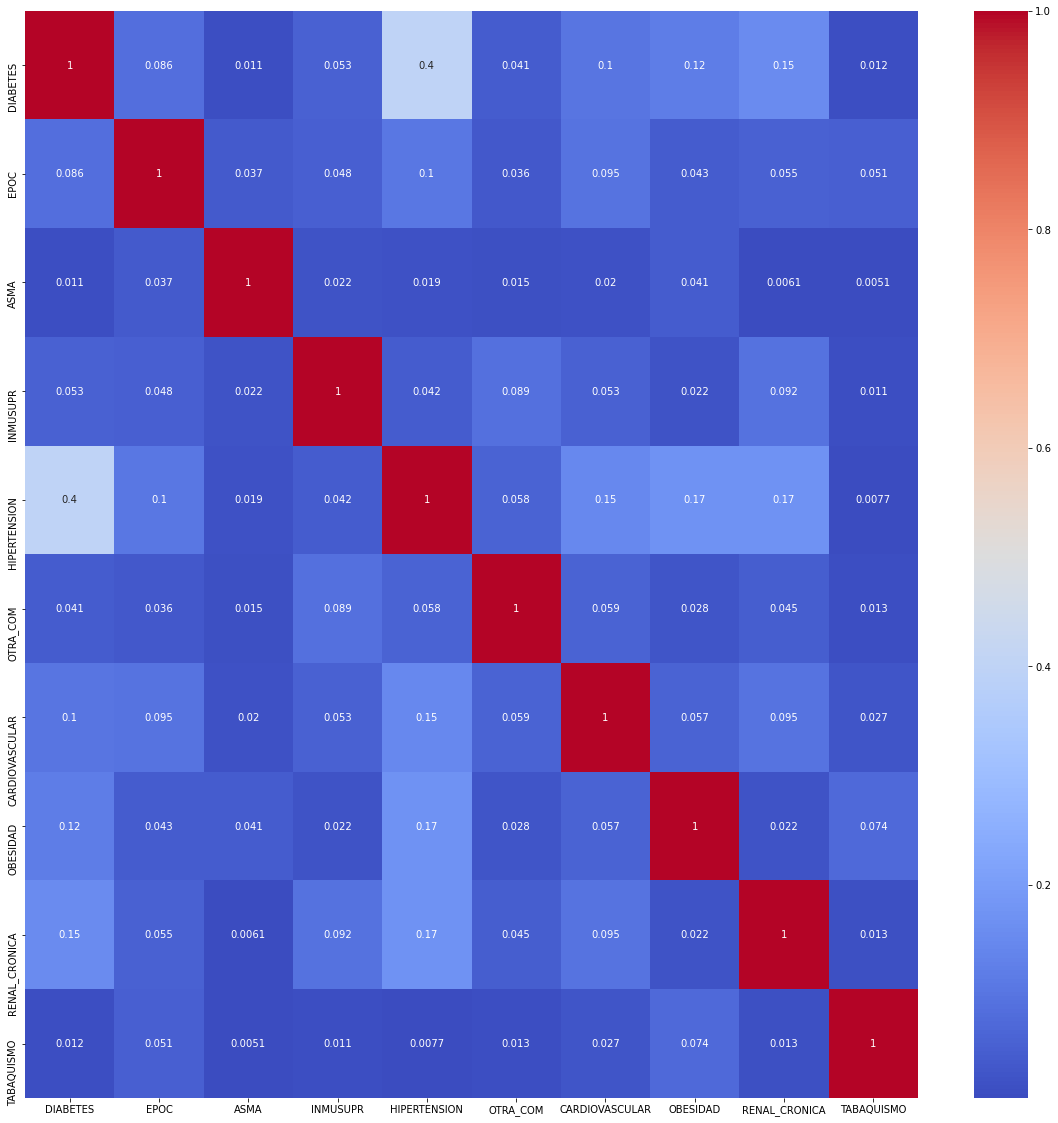

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline

data_ing_comorb = pd.read_csv('data_ing_comorb.csv', usecols = ['SEXO','DIABETES','EPOC','ASMA','INMUSUPR','HIPERTENSION','OTRA_COM','CARDIOVASCULAR','OBESIDAD','RENAL_CRONICA','TABAQUISMO'])

# get correlations of each features in dataset
corrmat = data_ing_comorb.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))

# plot heat.map

g = sns.heatmap(data_ing_comorb[top_corr_features].corr(), annot = True, cmap = 'coolwarm')

#data_ing_comorb.shape

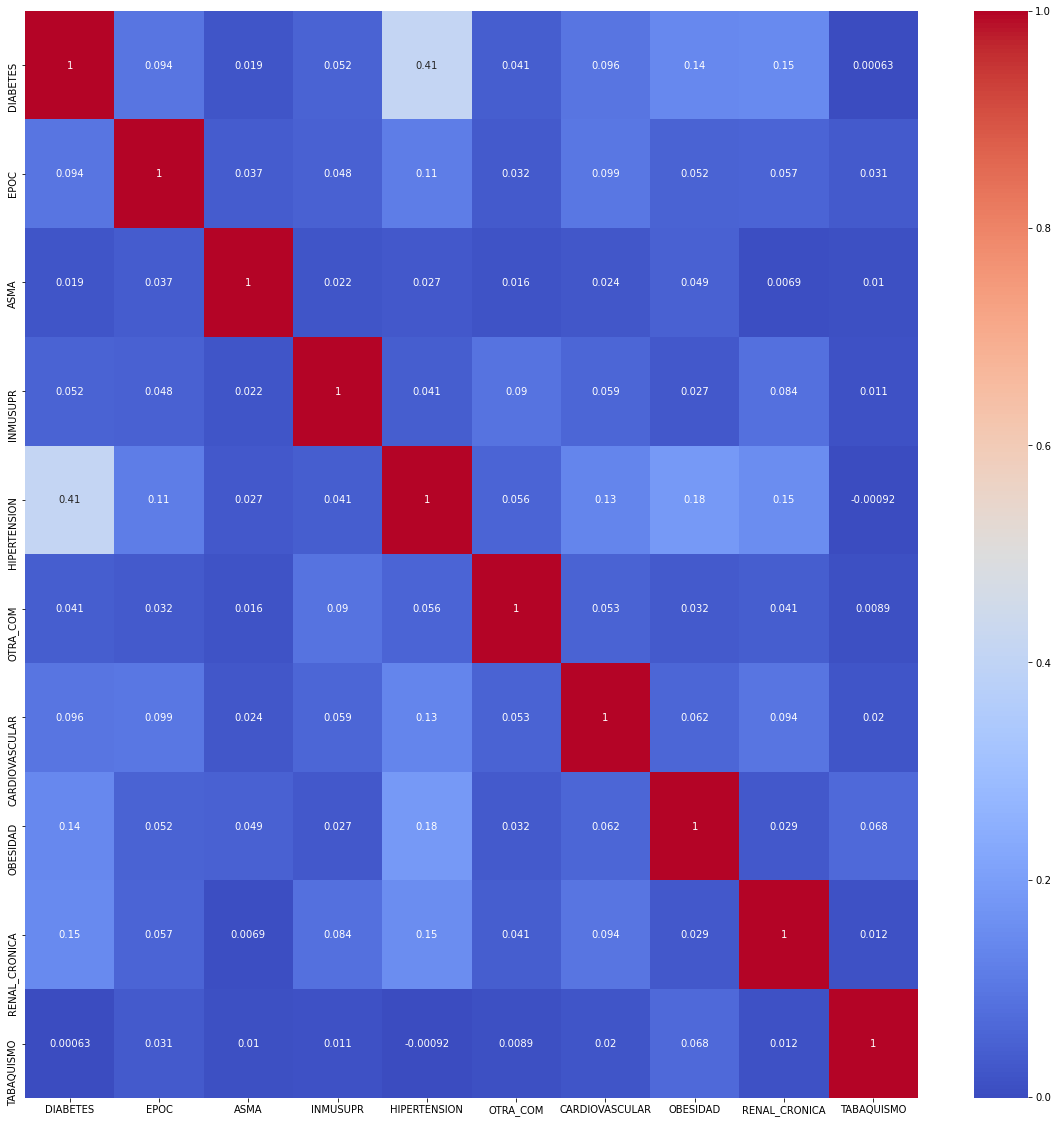

In [146]:
#sns.heatmap()
data_ing_comorb_muj = data_ing_comorb[data_ing_comorb['SEXO'].str.contains('Mujer')]
corrmat = data_ing_comorb_muj.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
g = sns.heatmap(data_ing_comorb_muj[top_corr_features].corr(), annot = True, cmap = 'coolwarm')

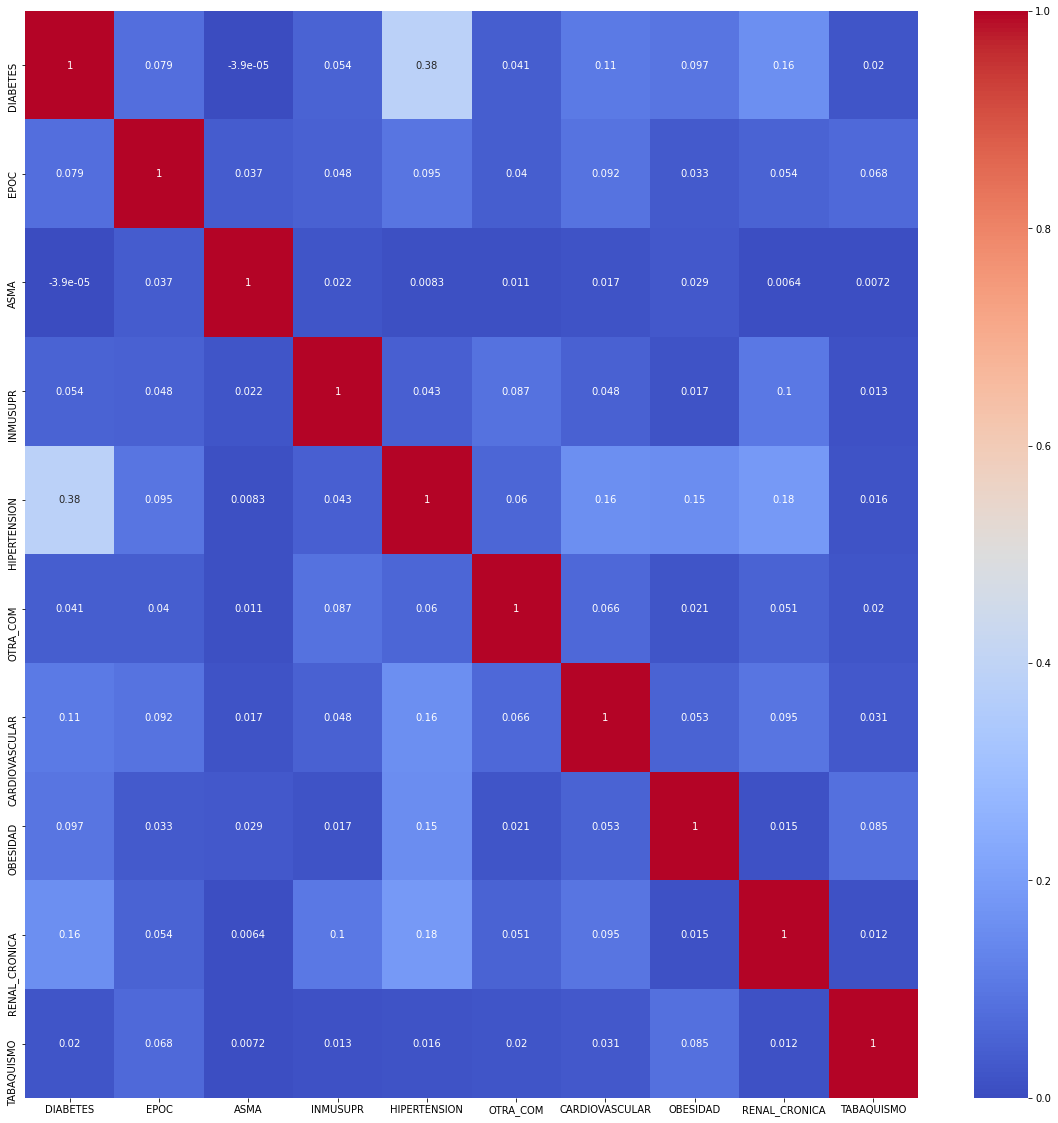

In [149]:
#sns.heatmap()
data_ing_comorb_hom = data_ing_comorb[data_ing_comorb['SEXO'].str.contains('Hombre')]
corrmat = data_ing_comorb_hom.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
g = sns.heatmap(data_ing_comorb_hom[top_corr_features].corr(), annot = True, cmap = 'coolwarm')

In [ ]:
import qgrid

#data_ing_2 = pd.read_csv('data_ing_2.csv')

widget = qgrid.show_grid(ing_x_dia)
widget

### Extraer data México

In [ ]:
mexico = data_ing_2.loc[data_ing_2['ENTIDAD_FEDERATIVA'] == 'MÉXICO']['ING_ACUM'].reset_index(drop = True)

In [ ]:
mexico

In [ ]:
data_new.loc[data_new["ENTIDAD_FEDERATIVA"] == "CIUDAD DE MÉXICO"].shape

In [ ]:
muestra

In [ ]:
dff = data[data['FECHA_INGRESO'].eq('2020-05-11')].sort_values(by='ing_cum', ascending = False)
ax.clear()

fig, ax = plt.subplots(figsize=(15, 8))

normal_colors = dict(zip(data['ENTIDAD_FEDERATIVA'].unique(), rgb_colors_opacity))
    
ax.barh(dff['ENTIDAD_FEDERATIVA'], dff['ing_cum'], color = [normal_colors[x] for x in dff['ENTIDAD_FEDERATIVA']])
dx = dff['ing_cum'].max() / 100

In [ ]:
draw_barchart('2020-05-11')

### Calcular Muestra

In [ ]:
# Muestra

current_date = '2021-12-01'
muestra = data_ing_2[data_ing_2['FECHA_INGRESO'].eq(current_date)].sort_values(by='ING_ACUM', ascending=False)

In [ ]:
muestra

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 8))
sns.set(style="darkgrid")
ax.barh(muestra['ENTIDAD_FEDERATIVA'], muestra['ING_ACUM'])

In [ ]:
# Extraer muestra data_ing_3

data_ing_3 = data_ing_2.set_index(['FECHA_INGRESO'])
data_ing_3 = (data_ing_3.loc['2021-11-01':'2021-12-01'])
data_ing_3

In [ ]:
data_ing_2.reset_index(inplace = True)
data_ing_2


### Calcular Muestra de un Día

In [ ]:
# Muestra
base_pareto_2 = pd.read_csv('base_pareto_final.csv')

current_date = '2021-01-25'
muestra = base_pareto_2[base_pareto_2['FECHA_INGRESO'].eq(current_date)]
muestra = muestra.set_index('ENTIDAD_FEDERATIVA')

### Calcular Rango-Muestra

In [ ]:
# Load data

rango_muestra = base_pareto_2[base_pareto_2['FECHA_INGRESO'].between('2021-01-01', '2021-02-01')]

In [ ]:
# Load data

rango_muestra = rango_muestra.set_index('ENTIDAD_FEDERATIVA')

In [15]:

#247455/1485
44819/7035*100
#22880/6431*100

637.0859985785359

In [16]:
censo_2020 = pd.read_csv('Censo_2020.csv')
censo_2020

,CLAVE_ENTIDAD,ENTIDAD_FEDERATIVA,ABREVIATURA,POBLACION_TOTAL_2020,PORCENTAJE
0,1,AGUASCALIENTES,AS,1425607.0,0.011
1,2,BAJA CALIFORNIA,BC,3769020.0,0.030
2,3,BAJA CALIFORNIA SUR,BS,798447.0,0.006
3,4,CAMPECHE,CC,928363.0,0.007
4,5,COAHUILA DE ZARAGOZA,CL,3146771.0,0.025
5,6,COLIMA,CM,731391.0,0.006
6,7,CHIAPAS,CS,5543828.0,0.044
7,8,CHIHUAHUA,CH,3741869.0,0.030
8,9,CIUDAD DE MÉXICO,DF,9209944.0,0.073
9,10,DURANGO,DG,1832650.0,0.015


In [25]:
# Select Hombre in DataFrame

data_def_2 = pd.read_csv('data_def_final.csv', sep = ',', 
                         #usecols = ['FECHA_DEF', 'ENTIDAD_FEDERATIVA', 'EVENTO']
                        )

#data_def_2[data_def_2['ENTIDAD_FEDERATIVA'].str.contains('MÉXICO')]

current_date = '2021-12-22'
data_def_2[data_def_2['FECHA_DEF'].eq(current_date)].sum()                         

Unnamed: 0                                                       373032
ENTIDAD_FEDERATIVA    AGUASCALIENTESBAJA CALIFORNIABAJA CALIFORNIA S...
FECHA_DEF             2021-12-222021-12-222021-12-222021-12-222021-1...
DEF_ACUM                                                       298359.0
dtype: object

In [26]:
(44819.0+32789)/298359

0.26011616877654103